In [34]:
import tensorflow as tf
import numpy as np
import pandas as pd
from keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt

# So we dont have to use plt.show() every time
%matplotlib inline

In [35]:
IMAGE_SIZE = 256
IMAGE_CHANNELS = 3
EPOCS = 10
BATCH_SIZE = 32

In [36]:
dataset = image_dataset_from_directory(
    directory="dataset",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    labels='inferred',
    shuffle=True,
)

Found 6652 files belonging to 6 classes.


In [37]:
CLASS_NAMES = dataset.class_names
print("Class names:", CLASS_NAMES)
print(len(dataset)*BATCH_SIZE)

Class names: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']
6656


Image batch shape: (32, 256, 256, 3)
Label batch as a tensor: tf.Tensor([4 5 0 5 0 4 4 1 1 4 1 0 4 5 3 3 3 3 5 3 5 1 1 3 0 4 0 5 1 3 5 3], shape=(32,), dtype=int32)
Label batch as numpy array: [4 5 0 5 0 4 4 1 1 4 1 0 4 5 3 3 3 3 5 3 5 1 1 3 0 4 0 5 1 3 5 3]
First image in batch raw tensor: tf.Tensor(
[[[120. 120. 122.]
  [120. 120. 122.]
  [119. 119. 121.]
  ...
  [124. 123. 129.]
  [119. 118. 124.]
  [116. 115. 121.]]

 [[112. 112. 114.]
  [114. 114. 116.]
  [116. 116. 118.]
  ...
  [127. 126. 132.]
  [126. 125. 131.]
  [125. 124. 130.]]

 [[108. 108. 110.]
  [111. 111. 113.]
  [115. 115. 117.]
  ...
  [126. 125. 131.]
  [127. 126. 132.]
  [127. 126. 132.]]

 ...

 [[ 98. 101. 106.]
  [ 96.  99. 104.]
  [ 93.  96. 101.]
  ...
  [108. 107. 112.]
  [104. 103. 108.]
  [109. 108. 113.]]

 [[100. 103. 108.]
  [ 98. 101. 106.]
  [ 95.  98. 103.]
  ...
  [109. 108. 113.]
  [106. 105. 110.]
  [ 98.  97. 102.]]

 [[103. 106. 111.]
  [100. 103. 108.]
  [ 97. 100. 105.]
  ...
  [112. 111. 116.]

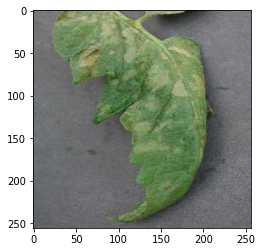

In [44]:
for image_batch, label_batch in dataset.take(1): # First batch
    print("Image batch shape:", image_batch.shape)
    print("Label batch as a tensor:", label_batch)
    print("Label batch as numpy array:", label_batch.numpy())
    print("First image in batch raw tensor:", image_batch[0])
    print("First image visualization:")
    plt.imshow(image_batch[0].numpy().astype(np.uint8))
    break

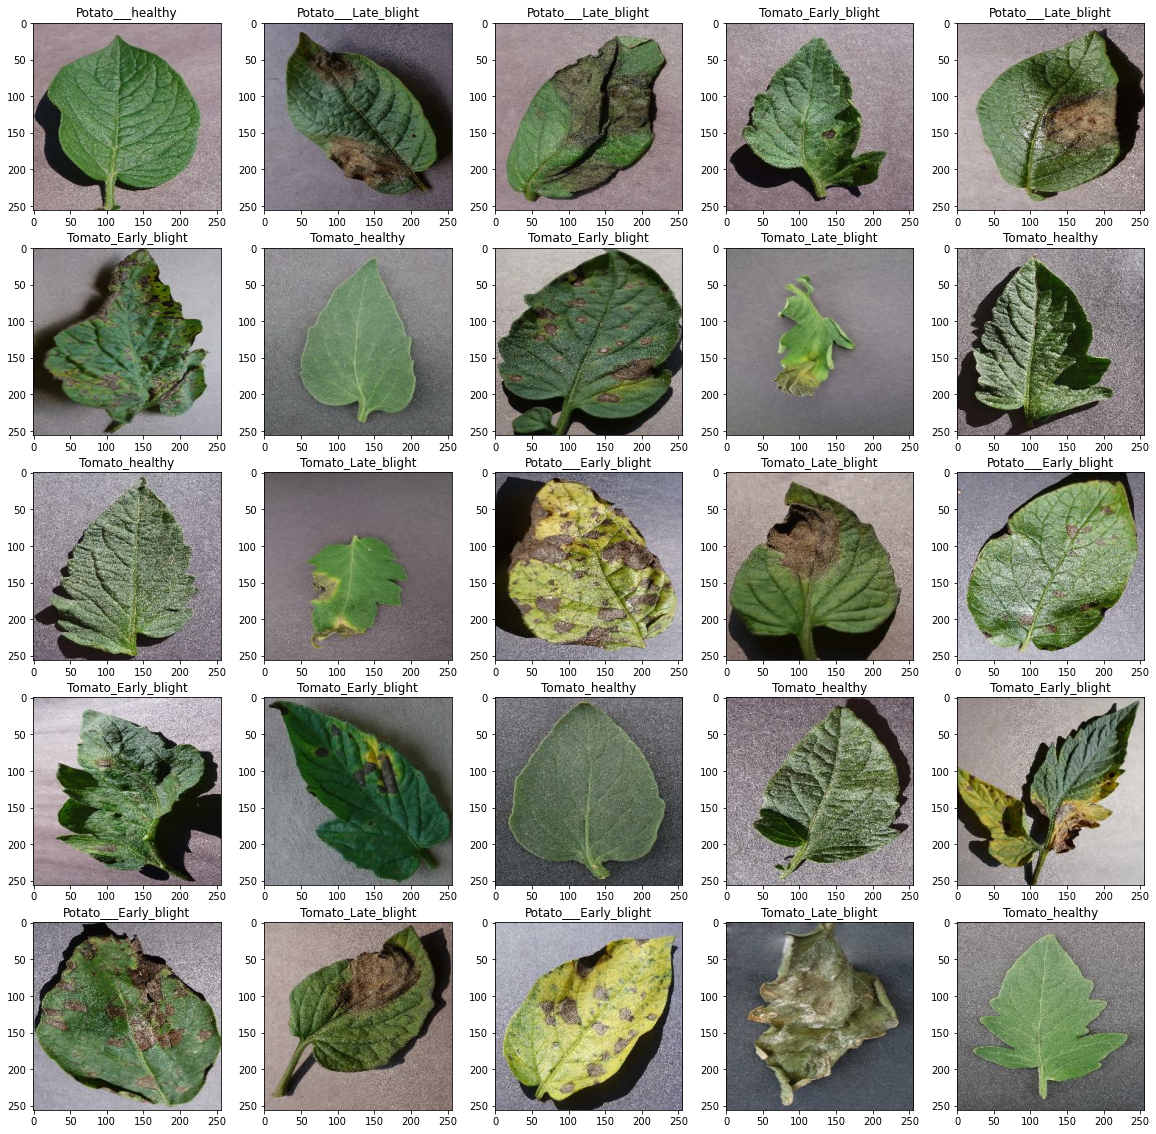

In [52]:

# plotting first 25 images in the batch
plt.figure(figsize=(20, 20))
for image_batch, label_batch in dataset.take(1):
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(image_batch[i].numpy().astype(np.uint8))
        plt.title(CLASS_NAMES[label_batch[i].numpy()])